In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

# from nnn import train_nn as tnn

## GNN

In [2]:
gnn_df = pd.read_csv('./data/wandb_gnn/wandb_export_2023-11-01T04_26_32.987-07_00.csv', index_col=0)

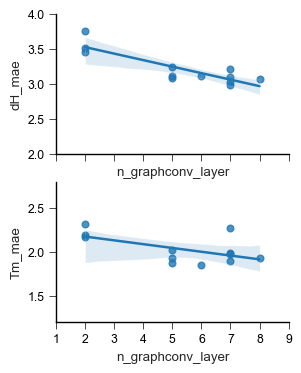

In [4]:
fig,ax = plt.subplots(2, 1, figsize=(3,4), sharex=True)
sns.regplot(
    data=gnn_df,
    y='dH_mae',
    x='n_graphconv_layer',
    ax=ax[0]
)

sns.regplot(
    data=gnn_df,
    y='Tm_mae',
    x='n_graphconv_layer',
    ax=ax[1]
)
ax[1].set_xlim([1,9])
# ax.set_ylim(bottom=0.2, top=.8)
ax[1].set_ylim(bottom=1.2, top=2.8)
ax[0].set_ylim(bottom=2, top=4)
util.beutify_all_ax(ax, x_locator=1)
util.save_fig('./fig/Fig5/n_conv_layer_importance.pdf')